# Obtain spatial resolved grain maps of PARADIM-2 in the focus beam

In [1]:
%run -i ../tomography/utils.py
%run -i startup2.py

Namespace: ['AzimuthalIntegrator', 'In', 'Out', 'ProgressBar', 'annotate_peaks', 'assign_Q_to_atlas', 'create_atlas', 'create_atlas_dask', 'create_dataset', 'create_grain_maps', 'create_windows_from_size', 'create_windows_from_width', 'dask', 'db_ana', 'db_csv', 'db_raw', 'df_uid', 'draw_windows', 'exit', 'get_ipython', 'get_vlim', 'min_and_max_along_time', 'mpl', 'my_print', 'np', 'patches', 'pd', 'pixel_to_Q', 'plot_grain_maps', 'plot_real_aspect', 'plt', 'quit', 'reformat_data', 'reshape', 'reshape_to_matrix', 'reshape_to_xarray', 'set_real_aspect', 'set_verbose', 'tp', 'track_peaks', 'typing', 'xr']


## Shadow method

### Load and reformat the data

In [2]:
df_uid.loc[0]

uid       4714edaf-227b-4caa-a53b-bc8bf110f7e5
sample                               PARAMID-2
task               a coarse grid rocking curve
beam                                     focus
Name: 0, dtype: object

In [3]:
run = db_raw[df_uid['uid'][0]]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [4]:
data

<xarray.Dataset>
Dimensions:               (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 4887)
Coordinates:
  * frame                 (frame) int64 0 1 2 3 4 5 ... 4882 4883 4884 4885 4886
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image          (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mXBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mXBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase                (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mYBase_user_setpoint  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

### Test the method

We iterate the images along the time series and find the maximum and minimum values on each pixel. The images of the maximum values are like a photo of all shadows of the Bragg peaks on the detector while the ones of the minimum values are like the record of the lowest background intensities on the images.

This method is implemented in `min_and_max_along_time`.

### Analyze the result

The method will catch the powder diffraction in it. We need to filter the images and only apply the method on the images of non-powder part.

In [6]:
shadows = xr.load_dataarray("/Volumes/STAO_EXT/test_with_powder_frames_array.nc")

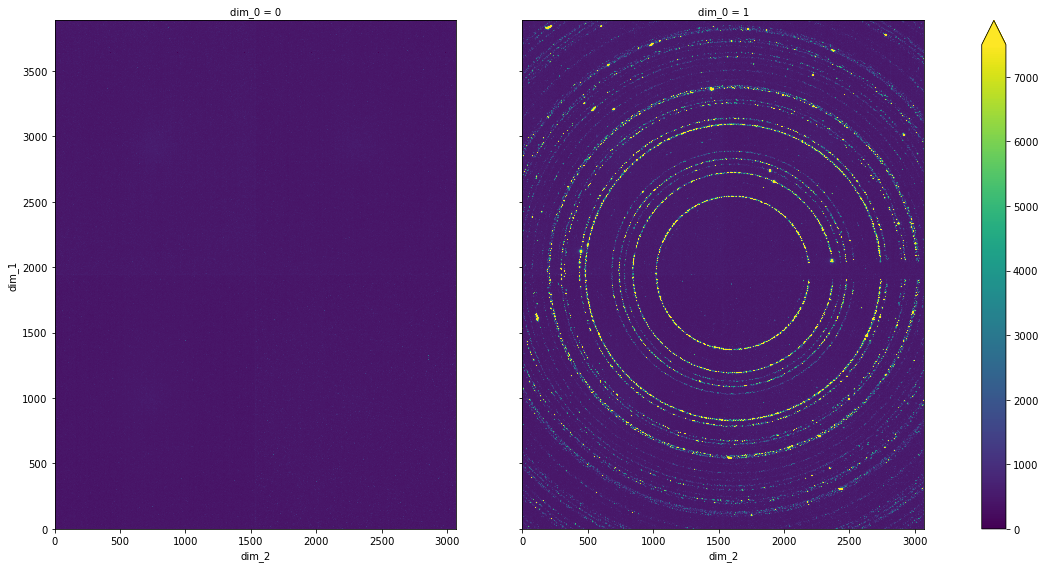

In [7]:
facet = shadows.plot(col="dim_0", vmax=7500, size=8)
set_real_aspect(facet.axes)

In [8]:
del shadows, facet

### Filter the images

We filter the images according to the `dexela_stats1_total` which is the sum of intensity on the image. The powder diffraction image has much higher intensity than the single crystal diffraction image and the air scattering image.

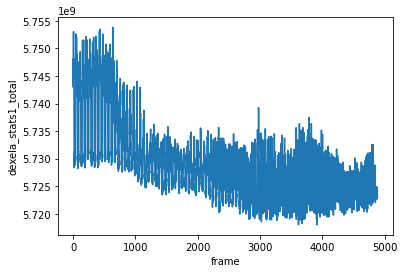

In [9]:
image_sum_data = data['dexela_stats1_total'].compute()
image_sum_data.plot();

If row >= 45, the frames are all from the single crystal diffraction images. We can use the frame index of them to select the valid images.

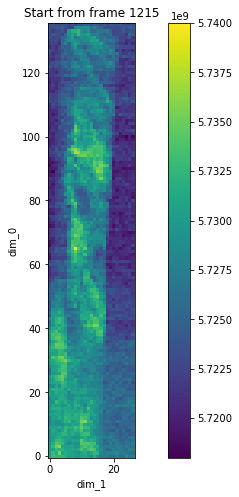

In [24]:
image_sum_matrix = reshape_to_xarray(image_sum_data, run.start)
facet = image_sum_matrix[45:].plot(size=8, vmax=5.74e9)
facet.axes.set_title("Start from frame {}".format(image_sum_matrix[45].frame.values.min()))
set_real_aspect(facet.axes)

In [25]:
del image_sum_data, image_sum_matrix, facet

### Run again with the filtered images

Get the maximum and minimum of pixel values for the images of the non-powder part.

In [27]:
shadows = xr.load_dataarray("/Volumes/STAO_EXT/test_filtered_frames_array.nc")

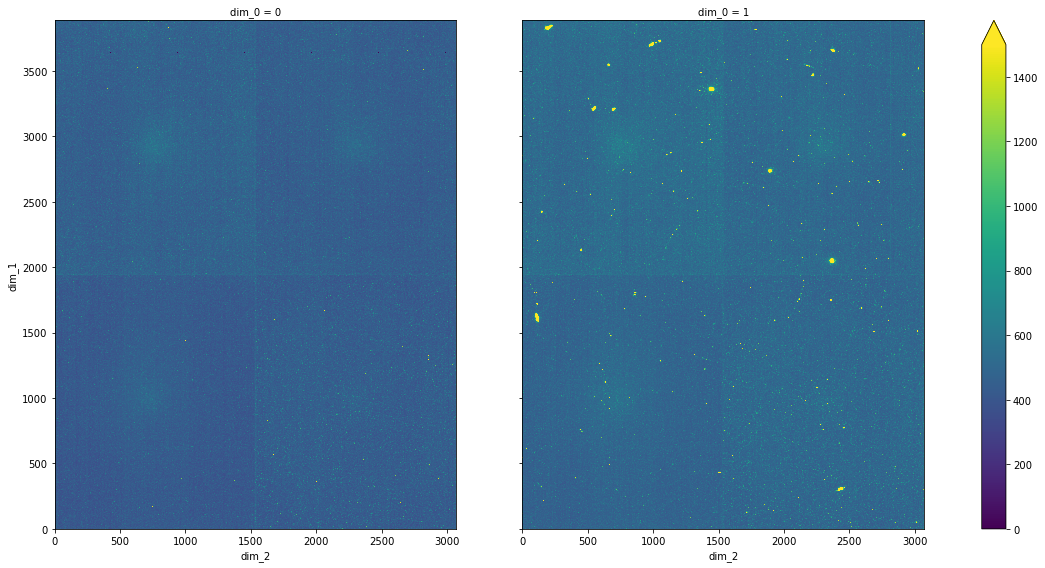

In [32]:
facet = shadows.plot(col="dim_0", size=8, vmax=1500)
set_real_aspect(facet.axes)

The result shows all the shinning points that ever appeared in any of the frames. Some look like Bragg peaks while the other look like a part of powder diffraction rings.

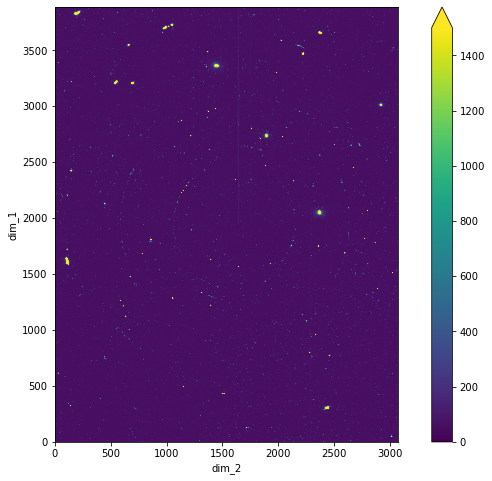

In [40]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

### Select the ones to track

We select the 20 largest peaks to track.

In [5]:
peaks = db_csv.get_df("60c140527b072673151c761e")
peaks = peaks.sort_values("mass", ascending=False).iloc[:20]
windows = create_windows_from_size(peaks, 4.5)

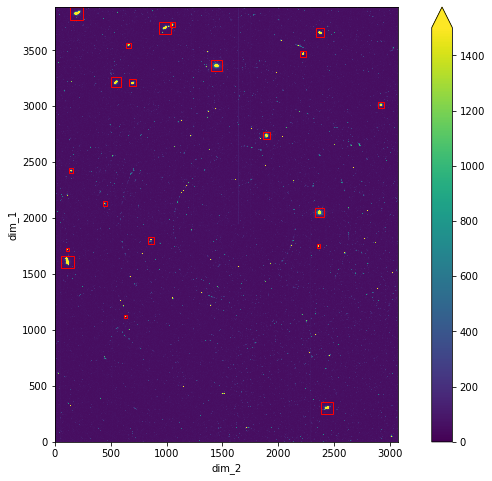

In [162]:
facet = subtracted_shadow.plot(size=8, vmax=1500)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)
plt.show()

### Run the tracking

### Visualize the grain maps

This is the final result of 20 grain maps. They are visualized in a log scale color map.

In [36]:
grains = xr.load_dataset("/Volumes/STAO_EXT/grain_maps_first_try.nc")
grains = grains.set_index({"grain": ["x", "y"]})

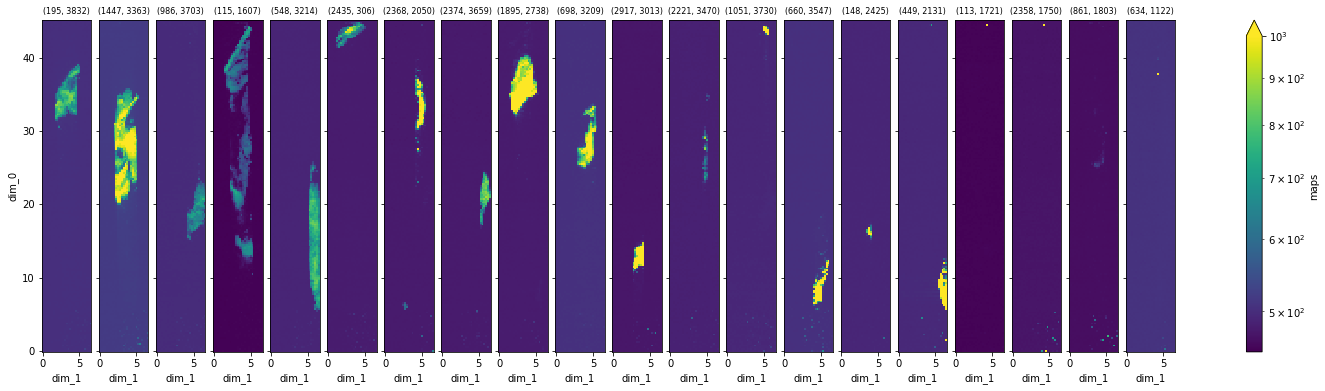

In [70]:
facet = plot_grain_maps(grains, norm=mpl.colors.LogNorm(vmax=1000))
facet.set_titles(template="{value}", size=8);

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [80]:
mean_map = grains["maps"].mean(axis=2)

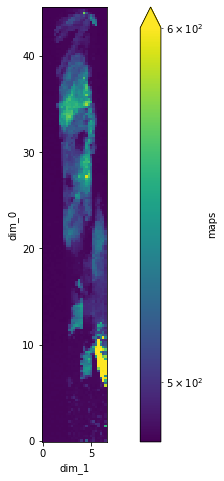

In [84]:
facet = mean_map.plot.pcolormesh(size=8, norm=mpl.colors.LogNorm(vmax=600))
set_real_aspect(facet.axes)